In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display

#%matplotlib notebook

import sys
import sklearn
#import pandas as pd
import matplotlib as mpl
#import matplotlib.pyplot as plt
import seaborn as sns

import re

%matplotlib inline

pd.options.display.max_rows = 10

### Зареждане и проверка на формата на данните:

In [2]:
multi = pd.read_csv('data/multipleChoiceResponses.csv', encoding='latin_1', low_memory=False)
free  = pd.read_csv('data/freeformResponses.csv', encoding='latin_1', low_memory=False)
print('multiple choice:', multi.shape)
print('free form:', free.shape)

multiple choice: (16716, 228)
free form: (16716, 62)


Ще започна с `multiple coice` данните, защото ми се вижда по-лесно.

### Наименования на колоните

In [3]:
multi.columns

Index(['GenderSelect', 'Country', 'Age', 'EmploymentStatus', 'StudentStatus',
       'LearningDataScience', 'CodeWriter', 'CareerSwitcher',
       'CurrentJobTitleSelect', 'TitleFit',
       ...
       'JobFactorExperienceLevel', 'JobFactorDepartment', 'JobFactorTitle',
       'JobFactorCompanyFunding', 'JobFactorImpact', 'JobFactorRemote',
       'JobFactorIndustry', 'JobFactorLeaderReputation', 'JobFactorDiversity',
       'JobFactorPublishingOpportunity'],
      dtype='object', length=228)

Всъщност имаме фаил с информация за колоните. Да не забравя, че тук може да се изпълняват bash команди.

In [4]:
!head data/schema.csv

schema.csv файла съдържа информация за:
 * наименованието на колоната използвано в другите файлове
 * въпроса зададен в анкетата, на който съответстват отговорите в данните
 * дали въпроса е за "множествен избор" или в свободна форма
 * дали въпроса е зададен на определена подгрупа респонденти

<a name="numeric_column_names"></a>Повечето от данните са категории а не числови 😣.

In [5]:
numeric_column_names = multi.describe().columns
print(numeric_column_names)

Index(['Age', 'LearningCategorySelftTaught', 'LearningCategoryOnlineCourses',
       'LearningCategoryWork', 'LearningCategoryUniversity',
       'LearningCategoryKaggle', 'LearningCategoryOther', 'TimeGatheringData',
       'TimeModelBuilding', 'TimeProduction', 'TimeVisualizing',
       'TimeFindingInsights', 'TimeOtherSelect'],
      dtype='object')


Колко празни са колоните с числови стойности? ([модел](#model))

In [6]:
for col in numeric_column_names:
    print(col, '# not NaNs:', sum(multi[col].isnull()))

Age # not NaNs: 331
LearningCategorySelftTaught # not NaNs: 3607
LearningCategoryOnlineCourses # not NaNs: 3590
LearningCategoryWork # not NaNs: 3605
LearningCategoryUniversity # not NaNs: 3594
LearningCategoryKaggle # not NaNs: 3590
LearningCategoryOther # not NaNs: 3622
TimeGatheringData # not NaNs: 9186
TimeModelBuilding # not NaNs: 9188
TimeProduction # not NaNs: 9199
TimeVisualizing # not NaNs: 9187
TimeFindingInsights # not NaNs: 9193
TimeOtherSelect # not NaNs: 9203


### Статистика на избрани колони:

#### Пол

In [7]:
print(multi.GenderSelect.value_counts())

Male                                                 13610
Female                                                2778
A different identity                                   159
Non-binary, genderqueer, or gender non-conforming       74
Name: GenderSelect, dtype: int64


Може и графгики:

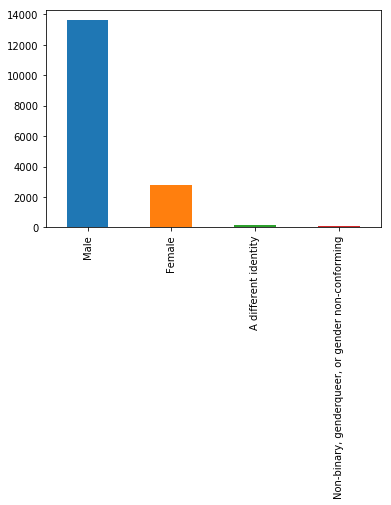

In [8]:
multi.GenderSelect.value_counts().plot(kind='bar');#, legend=True);

#### Държава:

In [9]:
print(multi.Country.value_counts())

United States     4197
India             2704
Other             1023
Russia             578
United Kingdom     535
                  ... 
Romania             59
Belarus             54
Czech Republic      53
Norway              53
Chile               51
Name: Country, Length: 52, dtype: int64


Целта на курса е догодина България да е в статистиката 😆

#### Възраст:

In [10]:
print(multi.Age.value_counts());

25.0    969
24.0    898
26.0    886
27.0    842
23.0    839
       ... 
83.0      1
94.0      1
10.0      1
82.0      1
9.0       1
Name: Age, Length: 84, dtype: int64


Интересно - точно десет от анкетираните са на 100 години 👴. Да видим и графично.

cannot convert float NaN to integer


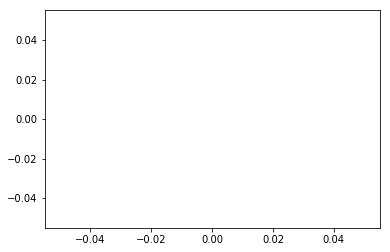

In [11]:
try:
    sns.distplot(multi.Age);
except ValueError as e:
    print(e)

Разбира се че ще има NaNs. Втори опит:

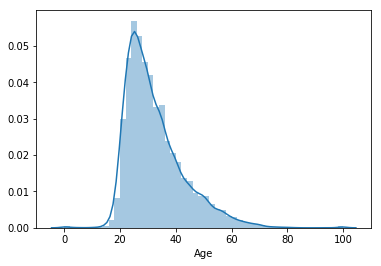

In [12]:
sns.distplot(multi.Age[multi.Age.notnull()]);

#### Заплати:

unsupported operand type(s) for /: 'str' and 'int'


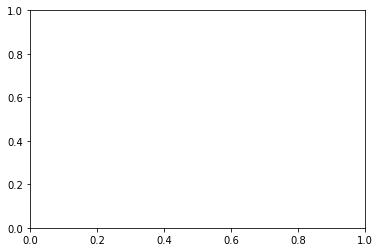

In [13]:
try:
    sns.distplot(multi.CompensationAmount[multi.CompensationAmount.notnull()]);
except TypeError as e:
    print(e)

Чудесно, сега и типа ще оправяме. След малко опити установих, че това е някаква легендарна структура, която миксира `float` за NaNs и `String` за числовите стойности:

In [14]:
multi[:20].CompensationAmount.apply(lambda x: print(x, type(x)));

nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
250,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
80000 <class 'str'>
1200000 <class 'str'>
nan <class 'float'>
95,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
1100000 <class 'str'>
120,000 <class 'str'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>
nan <class 'float'>


Следващия ред по принцип работи, но дава "FUTURE WARNING" 😕! (Отрязването [:0] е за да демонстрирам Warning-a без да печатам данните.)

In [15]:
multi[:0].CompensationAmount.convert_objects(convert_numeric=True)

/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


Series([], Name: CompensationAmount, dtype: object)

Ще пробвам да сменя типа по друг начин:

In [16]:
try:
    pd.to_numeric(multi.CompensationAmount, errors='raise')
except ValueError as e:
    print(e)

Unable to parse string "250,000" at position 3


Освен запетайка за хилядите, имаме още един чупещ символ - тире. Преди да презапишем в дата фрейма ще направим проверка.

In [17]:
temp = pd.to_numeric(multi.CompensationAmount.str.replace(',', '').replace('-', ''), errors='raise')
pd.DataFrame(data={'original': multi.CompensationAmount.iloc[10364:10374], 'new': temp[10364:10374]})

,new,original
10364,NaN,NaN
10365,NaN,-
10366,NaN,NaN
10367,NaN,NaN
10368,NaN,NaN
10369,NaN,NaN
10370,12000000.0,"12,000,000"
10371,NaN,NaN
10372,130000.0,130000
10373,90000.0,90000


Сега да омажем DataFrame-a

In [18]:
multi.CompensationAmount = pd.to_numeric(multi.CompensationAmount.str.replace(',', '').str.replace('-', ''), errors='raise')

Графика

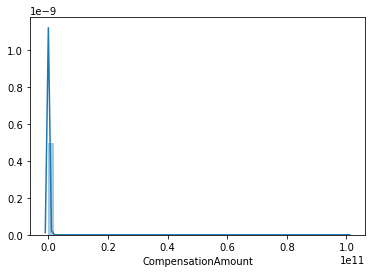

In [19]:
sns.distplot(multi.CompensationAmount[multi.CompensationAmount.notnull()]);

Я, някакви високи стойности изкривяват графиката.

In [20]:
compensation = pd.DataFrame(multi.CompensationAmount[multi.CompensationAmount.notnull()])
print(compensation.sort_values('CompensationAmount').head(5))
print(compensation.sort_values('CompensationAmount').tail(5))

       CompensationAmount
10525                 0.0
11978                 0.0
5960                  0.0
1693                  0.0
6420                  0.0
       CompensationAmount
9747         7.500000e+08
13418        8.000000e+08
5761         1.194000e+09
804          1.000000e+11
5458         1.000000e+11


Да видим дали превръщането към една валута ще помогне:

In [21]:
rates = pd.read_csv('data/conversionRates.csv', encoding='latin_1', low_memory=False)
rates[:10]

,Unnamed: 0,originCountry,exchangeRate
0,1,USD,1.000000
1,2,EUR,1.195826
2,3,INR,0.015620
3,4,GBP,1.324188
4,5,BRL,0.321350
5,6,RUB,0.017402
6,7,CAD,0.823688
7,8,AUD,0.802310
8,9,JPY,0.009108
9,10,CNY,0.153000


Искам да ползвам валутния код за индекс - за целта стойностите трябва да са уникални:

In [22]:
print('Има ли дупликати в originCountry?', all(rates.originCountry.duplicated()))

Има ли дупликати в originCountry? False


Тогава да сменим индекса:

In [23]:
rates = rates.set_index('originCountry')
print(rates.columns)

Index(['Unnamed: 0', 'exchangeRate'], dtype='object')


Да разкараме излишната колона:

In [24]:
rates = rates.drop('Unnamed: 0', axis=1)
rates[:10]

,exchangeRate
originCountry,
USD,1.000000
EUR,1.195826
INR,0.015620
GBP,1.324188
BRL,0.321350
RUB,0.017402
CAD,0.823688
AUD,0.802310
JPY,0.009108


Сега да проверим какви са данните за влутния код - има ли стойности в compensation за които липсва код

In [25]:
side_by_side = pd.DataFrame(data={'compensation': multi.CompensationAmount,
                                  'code': multi.CompensationCurrency})
print('общо данни:', len(side_by_side), '\nне-NaN compensation:',
      sum(side_by_side['compensation'].notnull()),
      '\nне-NaN compensation с валутен код NaN:',
      sum(side_by_side.code[side_by_side['compensation'].notnull()].isnull()))

some_partial_df = side_by_side.code[side_by_side['compensation'].notnull()]
another_partial_df = some_partial_df[some_partial_df.notnull()]
print('ползваеми данни:', len(another_partial_df))
# another_partial_df

общо данни: 16716 
не-NaN compensation: 5217 
не-NaN compensation с валутен код NaN: 843
ползваеми данни: 4374


Тъй като искам само да видя нормална графика, няма да бутам основния дата фрейм а ще си направя нов, който съдържа само данните с които ще чартая.

In [26]:
plotable_compensation = multi.dropna(axis=0, subset=['CompensationCurrency', 'CompensationAmount'])
plotable_compensation

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Female,Australia,43.0,Employed full-time,NaN,NaN,Yes,NaN,Business Analyst,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Male,Russia,33.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Male,India,27.0,Employed full-time,NaN,NaN,Yes,NaN,Data Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,Male,Taiwan,26.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,Male,Other,56.0,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16517,Male,Germany,34.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16525,Male,United States,50.0,Employed full-time,NaN,NaN,Yes,NaN,Data Scientist,Perfectly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16577,Male,Norway,32.0,Employed full-time,NaN,NaN,Yes,NaN,Data Analyst,Perfectly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Да калкулираме компенсацията в USD:

In [27]:
try:
    plotable_compensation['compensation'] = plotable_compensation.apply(lambda row:
        row['CompensationAmount'] * rates.loc[row['CompensationCurrency']], axis=1)
except KeyError as e:
    print(e)

('the label [SPL] is not in the [index]', 'occurred at index 12623')


Разбира се че ще има нечия заплата дадена в [Себоргийско](https://bg.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B1%D0%BE%D1%80%D0%B3%D0%B0) Луиджино, а други изненади има ли?

In [28]:
set(plotable_compensation.CompensationCurrency.unique()) - set(rates.index)

{'SPL'}

Просто ще го добавим - проверих курса USD/SPL = 6

In [29]:
rates.loc['SPL'] = 6.0
print('Валути използвани в multipleChoiceResponses.csv, но липсващи в conversionRates.csv:',\
      list(set(plotable_compensation.CompensationCurrency.unique()) - set(rates.index)))

Валути използвани в multipleChoiceResponses.csv, но липсващи в conversionRates.csv: []


Пореден опит за калкулираме компенсацията в USD:

In [30]:
plotable_compensation['compensation'] = plotable_compensation.apply(
    lambda row: row['CompensationAmount'] * rates.loc[row['CompensationCurrency']], axis=1)
plotable_compensation.compensation

/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


3        250000.000
8         64184.800
9         20882.400
11         1483.900
14        36634.400
            ...    
16507     50000.000
16517    100449.384
16525    200000.000
16577     89686.950
16700     10000.000
Name: compensation, Length: 4374, dtype: float64

Мина. Да видим графиката:

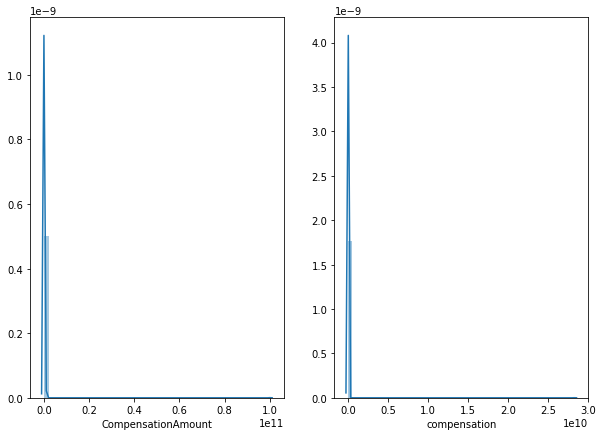

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=False)
sns.distplot(compensation.CompensationAmount, ax=axes[0])
sns.distplot(plotable_compensation.compensation, ax=axes[1]);

Явно корекцията от валутния курс не е достатъчна. Да видим данните - какви са тия милиони?

In [32]:
pd.options.display.max_rows = 20
pd.set_option('display.float_format', '{:.2f}'.format)

selected = plotable_compensation.sort_values('compensation', ascending=False)[['CompensationAmount',
                                    'compensation', 'CompensationCurrency', 'Country']]
selected.head(20)

,CompensationAmount,compensation,CompensationCurrency,Country
5458,100000000000.00,28297400000.00,ILS,United Kingdom
804,100000000000.00,209000000.00,AMD,United States
3013,9999999.00,9999999.00,USD,People 's Republic of China
15678,14000000.00,4498900.00,BRL,Brazil
12531,2500000.00,2500000.00,USD,United States
4481,2400000.00,2395468.80,BSD,Other
12808,2000000.00,2000000.00,USD,United Kingdom
11970,25000000.00,1059875.00,ETB,Other
8880,1000000.00,1000000.00,USD,Taiwan
1514,1000000.00,1000000.00,USD,United States


Не можах да излъжа Pandas, хем да ми форматира числата без научна нотация, хем да маркира с цвят. Плзването на highlight изглежда ресет-ва формата на нотацията. 

In [33]:
# pd.reset_option('display.float_format')
selected[:20].style.apply(lambda x:
                     ['background: lightblue' if x.name == 'compensation' and
                      isinstance(z, float) and z >= 1e+06 else
                      '' for i,z in x.iteritems()])

,CompensationAmount,compensation,CompensationCurrency,Country
5458,1e+11,2.82974e+10,ILS,United Kingdom
804,1e+11,2.09e+08,AMD,United States
3013,1e+07,1e+07,USD,People 's Republic of China
15678,1.4e+07,4.4989e+06,BRL,Brazil
12531,2.5e+06,2.5e+06,USD,United States
4481,2.4e+06,2.39547e+06,BSD,Other
12808,2e+06,2e+06,USD,United Kingdom
11970,2.5e+07,1.05988e+06,ETB,Other
8880,1e+06,1e+06,USD,Taiwan
1514,1e+06,1e+06,USD,United States


ОК, тия с най-големите суми са очевидни тролове, останалите с милион и на горе са допуснали техническа грешка при броя на нулите.

In [34]:
rows_to_delete = selected[selected['compensation'] >= 1e+6].index
print('редове за премахване:', rows_to_delete)
selected.drop(rows_to_delete, inplace=True)
selected[:20].style.apply(lambda x: ['background: lightgreen' if x.name == 'compensation' and isinstance(z, float) and z >= 400000 else '' for i,z in x.iteritems()])

редове за премахване: Int64Index([5458, 804, 3013, 15678, 12531, 4481, 12808, 11970, 8880, 1514, 993,
            11689],
           dtype='int64')


,CompensationAmount,compensation,CompensationCurrency,Country
10601,7e+06,699090,VEF,Other
12623,115000,690000,SPL,United States
2538,450000,595885,GBP,United Kingdom
15494,550000,550000,USD,United States
9224,500000,500000,USD,United States
419,470000,470000,USD,United States
9206,3e+06,459000,CNY,People 's Republic of China
6357,400000,400000,USD,United States
6301,400000,400000,USD,Australia
3743,400000,400000,USD,Other


Да видим графиката:

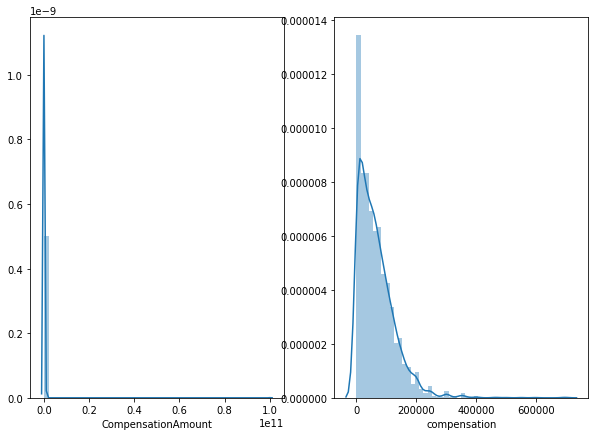

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=False)
sns.distplot(compensation.CompensationAmount, ax=axes[0])
sns.distplot(selected.compensation, ax=axes[1]);

Така е по-добре.

#### Платформа за обучение:

In [36]:
pd.options.display.max_rows = 20
multi.LearningPlatformSelect

0        College/University,Conferences,Podcasts,Trade ...
1                                                   Kaggle
2        Arxiv,College/University,Kaggle,Online courses...
3        Blogs,College/University,Conferences,Friends n...
4                        Arxiv,Conferences,Kaggle,Textbook
5        Kaggle,Online courses,Stack Overflow Q&A,Textbook
6            Arxiv,Blogs,Kaggle,Personal Projects,Textbook
7        College/University,Kaggle,Online courses,Stack...
8        Blogs,Company internal community,Conferences,F...
9        Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...
                               ...                        
16706                                                  NaN
16707                                                  NaN
16708                                                  NaN
16709                                                  NaN
16710                                                  NaN
16711                                                  N

In [37]:
pd.options.display.max_rows = 10

`DataFrame` обекти се форматират в таблици - така е по-четимо.

In [38]:
pd.DataFrame(multi.LearningPlatformSelect.value_counts())

,LearningPlatformSelect
Kaggle,210
Online courses,209
Personal Projects,155
College/University,127
YouTube Videos,127
...,...
"Blogs,Company internal community,Conferences,Personal Projects,Podcasts,Stack Overflow Q&A,YouTube Videos",1
"Arxiv,Official documentation,Online courses,Personal Projects,Textbook",1
"College/University,Company internal community,Conferences,Kaggle,Textbook,YouTube Videos",1
"Conferences,Kaggle,Official documentation,Stack Overflow Q&A,Textbook",1


Ясно е, че отговорите на въпроса са конкатанирани в стринг и ще трябва да се разбият на отделни колони. За целта първо ще зачистим NaNs.

In [39]:
multi['LearningPlatformSelect'] = multi['LearningPlatformSelect'].fillna('')
multi.LearningPlatformSelect

0        College/University,Conferences,Podcasts,Trade ...
1                                                   Kaggle
2        Arxiv,College/University,Kaggle,Online courses...
3        Blogs,College/University,Conferences,Friends n...
4                        Arxiv,Conferences,Kaggle,Textbook
                               ...                        
16711                                                     
16712    Kaggle,Non-Kaggle online communities,Online co...
16713                                                     
16714                                                     
16715                                                     
Name: LearningPlatformSelect, Length: 16716, dtype: object

Да съберем речник от възможните стойности:

In [40]:
accumulator = set([])
multi.apply(lambda row: accumulator.update(set(row['LearningPlatformSelect'].split(','))), axis=1)
accumulator = accumulator - set([''])
print('Брой платформи:',len(accumulator))
print(accumulator)

Брой платформи: 19
{'Newsletters', 'College/University', 'Personal Projects', 'Other', 'Kaggle', 'Company internal community', 'Online courses', 'Trade book', 'Stack Overflow Q&A', 'Blogs', 'Arxiv', 'Official documentation', 'Friends network', 'Podcasts', 'Textbook', 'YouTube Videos', 'Conferences', 'Non-Kaggle online communities', 'Tutoring/mentoring'}


Имам чувството, че този фичър няма да е единствения, при който ще е нужно подобно преформатиране. Затова ще си напиша процедура. (вариант с scikit-learn трансформер ще пробвам в следващия notebook)

In [41]:
def TextToOneHot(source_df, target_feature, categories=None,\
                 separator=',', fillna='NA', drop_target_at_fin=False):
    # Returns new DataFrame with OneHotEncoding of Categories
    #    extracted from the text of the target feature.
    
    # backup the data
    df = source_df.copy()
    
    # clear NaNs
    df[target_feature] = df[target_feature].fillna(fillna)
    
    # extract categories, if not provided
    if not categories:
        categories = set([])
        df.apply(lambda row: categories.update(set(row[target_feature].split(separator))), axis=1)
        
    # loop the categories and map to new features
    pattern = re.compile('[\W]+')
    for category in categories:
        new_feature_name = target_feature + '_' + category.replace(' ', '_')
        new_feature_name = pattern.sub('', new_feature_name)
        df[new_feature_name] = df.apply(lambda row: float(bool(row[target_feature].count(category))), axis=1)
    
    if drop_target_at_fin:
        df.drop(target_feature, axis=1, inplace=True)
    
    return df


Първо ще тествам с откъс от данните - приготвям dummy_df:

In [42]:
dummy_data = [
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,College/University,Kaggle,Online courses,YouTube Videos", "Very useful"],
    ["GitHub", "Arxiv,Conferences,Kaggle,Textbook", "Very useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,Kaggle,Personal Projects,Textbook", "Somewhat useful"],
    ["I collect my own data (e.g. web-scraping)",
    "Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle online communities,Official documentation,Online courses,\
    Personal Projects,Podcasts,Stack Overflow Q&A,Textbook,YouTube Videos",
    "Somewhat useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,College/University,Kaggle,Stack Overflow Q&A,Textbook,Tutoring/mentoring",
    "Somewhat useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,Company internal community,Conferences,Kaggle,Non-Kaggle online communities,Personal Projects,\
    Podcasts,Stack Overflow Q&A,Textbook,YouTube Videos", "Very useful"],
    ["Google Search", "Arxiv,Blogs,College/University,Company internal community,Conferences,Kaggle,Newsletters,\
    Non-Kaggle online communities,Official documentation,Online courses,Personal Projects,Podcasts,\
    Stack Overflow Q&A,Textbook,Trade book,Tutoring/mentoring,YouTube Videos", "Very useful"],
    ["I collect my own data (e.g. web-scraping)",
    "Arxiv,Blogs,Kaggle,Online courses,Personal Projects,Stack Overflow Q&A,YouTube Videos", "Very useful"],
    ["University/Non-profit research group websites",
    "Arxiv,Blogs,College/University,Conferences,Kaggle,Non-Kaggle online communities,Official documentation,\
    Stack Overflow Q&A", "Very useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,College/University,Kaggle,Newsletters,Stack Overflow Q&A,YouTube Videos", "Very useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,College/University,Company internal community,Friends network,Kaggle,\
    Non-Kaggle online communities,Official documentation,Online courses,Personal Projects,\
    Stack Overflow Q&A,Textbook,YouTube Videos", "Somewhat useful"],
    ["University/Non-profit research group websites",
    "Arxiv,Kaggle,Official documentation,Online courses,Stack Overflow Q&A,YouTube Videos", "Somewhat useful"],
    ["Dataset aggregator/platform (i.e. Socrata/Kaggle Datasets/data.world/etc.)",
    "Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle online communities", "Very useful"]
]

dummy_df = pd.DataFrame(data=dummy_data)
dummy_df.columns = ['PersonalProjectsChallengeFreeForm','LearningPlatformSelect','LearningPlatformCommunityFreeForm']

# adding NaN to make it more realistic
dummy_df['LearningPlatformSelect'][8] = None
dummy_df

,PersonalProjectsChallengeFreeForm,LearningPlatformSelect,LearningPlatformCommunityFreeForm
0,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Online courses...",Very useful
1,GitHub,"Arxiv,Conferences,Kaggle,Textbook",Very useful
2,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,Kaggle,Personal Projects,Textbook",Somewhat useful
3,I collect my own data (e.g. web-scraping),"Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...",Somewhat useful
4,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Stack Overflow...",Somewhat useful
...,...,...,...
8,University/Non-profit research group websites,None,Very useful
9,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Kaggle,Newslett...",Very useful
10,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Company interna...",Somewhat useful
11,University/Non-profit research group websites,"Arxiv,Kaggle,Official documentation,Online cou...",Somewhat useful


Прилагаме процедурата за енкодинг и получаваме една камара колони:

In [43]:
new_df = TextToOneHot(dummy_df, 'LearningPlatformSelect')
new_df

,PersonalProjectsChallengeFreeForm,LearningPlatformSelect,LearningPlatformCommunityFreeForm,LearningPlatformSelect_Newsletters,LearningPlatformSelect_____Podcasts,LearningPlatformSelect_CollegeUniversity,LearningPlatformSelect_Personal_Projects,LearningPlatformSelect_Kaggle,LearningPlatformSelect_Company_internal_community,LearningPlatformSelect_Online_courses,...,LearningPlatformSelect_____NonKaggle_online_communities,LearningPlatformSelect_Official_documentation,LearningPlatformSelect_Friends_network,LearningPlatformSelect_____Stack_Overflow_QA,LearningPlatformSelect_Podcasts,LearningPlatformSelect_Textbook,LearningPlatformSelect_YouTube_Videos,LearningPlatformSelect_Conferences,LearningPlatformSelect_NonKaggle_online_communities,LearningPlatformSelect_Tutoringmentoring
0,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Online courses...",Very useful,0.00,0.00,1.00,0.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
1,GitHub,"Arxiv,Conferences,Kaggle,Textbook",Very useful,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
2,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,Kaggle,Personal Projects,Textbook",Somewhat useful,0.00,0.00,0.00,1.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
3,I collect my own data (e.g. web-scraping),"Arxiv,Blogs,Conferences,Kaggle,Non-Kaggle onli...",Somewhat useful,0.00,0.00,0.00,1.00,1.00,0.00,1.00,...,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,0.00
4,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,College/University,Kaggle,Stack Overflow...",Somewhat useful,0.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,University/Non-profit research group websites,NA,Very useful,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Kaggle,Newslett...",Very useful,1.00,0.00,1.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
10,Dataset aggregator/platform (i.e. Socrata/Kagg...,"Arxiv,Blogs,College/University,Company interna...",Somewhat useful,0.00,0.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00
11,University/Non-profit research group websites,"Arxiv,Kaggle,Official documentation,Online cou...",Somewhat useful,0.00,0.00,0.00,0.00,1.00,0.00,1.00,...,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00


Бъркане по колоните на сляпо е доста безполезно. Преди да избера друг подход трябва да си определя цел:
 * да изследвам определени отношения между характеристики - например:
    * има ли зависимост между пол и заплата (Compensation)
 * да тренирам конкретен модел - например:
    * предсказване на Compensation въз основа на избрани характеристики възраст и държава
    * предсказване на Compensation въз основа на всички multipleChoice характеристики
    * предсказване на Compensation въз основа на multipleChoice + Freeform характеристики
    
Предполагам, че ще потренирам по избрани характеристики. Ако е нужно лесно могат да се добавят други характеристики в последствие. 

### Моделиране<a name="model"></a>

#### Подбор на данните

Реших, че е най-интересно да моделирам Compensation въз основа на избрани характеристики, като възраст, държава и др.





Първо да извадим избраните колони в нови DataFrame-и x & y.

In [44]:
x = pd.DataFrame(data={'Sex': multi.GenderSelect, 'Age': multi.Age, 'Country': multi.Country, 'Job': multi.CurrentJobTitleSelect, 'Platform': multi.LearningPlatformSelect})
x

,Age,Country,Job,Platform,Sex
0,nan,NaN,DBA/Database Engineer,"College/University,Conferences,Podcasts,Trade ...","Non-binary, genderqueer, or gender non-conforming"
1,30.00,United States,NaN,Kaggle,Female
2,28.00,Canada,NaN,"Arxiv,College/University,Kaggle,Online courses...",Male
3,56.00,United States,Operations Research Practitioner,"Blogs,College/University,Conferences,Friends n...",Male
4,38.00,Taiwan,Computer Scientist,"Arxiv,Conferences,Kaggle,Textbook",Male
...,...,...,...,...,...
16711,24.00,Other,NaN,,Female
16712,25.00,Indonesia,Programmer,"Kaggle,Non-Kaggle online communities,Online co...",Male
16713,25.00,Taiwan,NaN,,Female
16714,16.00,Singapore,NaN,,Female


In [45]:
for col in x.columns:
    print(col, 'брой NaN:', sum(x[col].isnull()) )

Age брой NaN: 331
Country брой NaN: 121
Job брой NaN: 4886
Platform брой NaN: 0
Sex брой NaN: 95


За Y ще ползваме вече обработената колона 'compensation' в която компенсацията е сметната в USD. Тя в наивно именования датасет 'plotable_compensation'.

In [46]:
y = pd.DataFrame(data={'Compensation': plotable_compensation.compensation})
y

,Compensation
3,250000.00
8,64184.80
9,20882.40
11,1483.90
14,36634.40
...,...
16507,50000.00
16517,100449.38
16525,200000.00
16577,89686.95


Опа, тук сме затрили редовете с NaN стойности, та "формите" на датасетовете x & y не съвпадат:

In [47]:
print('x: ', x.shape)
print('y: ', y.shape)

x:  (16716, 5)
y:  (4374, 1)


Тъй като индексите на у са запазени, можем да затрием съответните редове от х:

In [48]:
x = x.reindex(y.index)
print('x: ', x.shape)
print('y: ', y.shape)

x:  (4374, 5)
y:  (4374, 1)


Да нацепим💪 данните на тренировачни и тестови:

In [49]:
from sklearn.model_selection import train_test_split

# %reset_selective -f [xy]_t....?

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    random_state=1337)

[ print(z.shape) for z in [x_train, x_test, y_train, y_test] ];

(3061, 5)
(1313, 5)
(3061, 1)
(1313, 1)


Въпрос - трябваше ли да разделя данните преди да зачистя NaN записите от у? Аз поне не виждам причина. 

Този път ще ползвам **CountVectorizer** за да хвана уникалните стойности за категорията Platform. 

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

# cv = CountVectorizer(token_pattern=r'(?<=(,|\A))[^,"]+?(?=[,$])')
# cv = CountVectorizer(token_pattern=r'(?<=(,|^))[^,"]+?(?=[,$])')
cv = CountVectorizer(token_pattern=r'[^,]+')

cv.fit(x_train.Platform)
print('Намерени категории:', len(cv.get_feature_names()))
cv.get_feature_names()

Намерени категории: 19


['arxiv',
 'blogs',
 'college/university',
 'company internal community',
 'conferences',
 'friends network',
 'kaggle',
 'newsletters',
 'non-kaggle online communities',
 'official documentation',
 'online courses',
 'other',
 'personal projects',
 'podcasts',
 'stack overflow q&a',
 'textbook',
 'trade book',
 'tutoring/mentoring',
 'youtube videos']

Каква е разликата между **.vocabulary_.items()** и **.get_feature_names()**

In [51]:
set(cv.get_feature_names()) - set(cv.vocabulary_.keys())

set()

Проверка на резултатите спрямо предишния речник.

In [52]:
cv.vocabulary_.items()
set([ z.lower() for z in accumulator]) - set(cv.vocabulary_.keys())

set()

In [53]:
encoded_platforms_matrix = cv.fit_transform(x_train.Platform)
print(encoded_platforms_matrix[:20].todense())

[[0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1]
 [0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1]
 [1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1]
 [1 1 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1]
 [0 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1]
 [1 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0]
 [1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1]
 [0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0]
 [1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 0]
 [0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0]]


In [54]:
encoded_platforms = pd.DataFrame(data=encoded_platforms_matrix.todense(), index=x_train.index, columns=cv.get_feature_names())
encoded_platforms

,arxiv,blogs,college/university,company internal community,conferences,friends network,kaggle,newsletters,non-kaggle online communities,official documentation,online courses,other,personal projects,podcasts,stack overflow q&a,textbook,trade book,tutoring/mentoring,youtube videos
8416,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
3587,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1
11542,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
5581,1,1,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,1
16134,1,1,1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
3547,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,0,0,0
2598,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
728,1,1,1,0,1,1,1,0,0,0,0,0,0,0,1,0,0,1,0


In [55]:
x_train.iloc[0].Platform

'Blogs,Kaggle,Online courses,Stack Overflow Q&A,YouTube Videos'

In [56]:
x_train

,Age,Country,Job,Platform,Sex
8416,27.00,Israel,Scientist/Researcher,"Blogs,Kaggle,Online courses,Stack Overflow Q&A...",Female
3587,56.00,United States,Statistician,"Company internal community,Online courses,Pers...",Male
11542,35.00,Other,Data Scientist,"Blogs,College/University,Kaggle,Online courses...",Male
5581,34.00,United States,Other,"Arxiv,Blogs,Company internal community,Confere...",Male
16134,29.00,Romania,Researcher,"Arxiv,Blogs,College/University,Conferences,Kag...",Female
...,...,...,...,...,...
10424,31.00,Chile,Data Scientist,"Official documentation,Online courses,Stack Ov...",Female
3547,26.00,Mexico,Computer Scientist,"Blogs,College/University,Conferences,Friends n...",Male
2598,43.00,South Africa,Data Scientist,"Arxiv,Company internal community,Conferences,K...",Male
728,25.00,United States,Scientist/Researcher,"Arxiv,Blogs,College/University,Conferences,Fri...",Male


In [57]:
concatenated = pd.concat([x_train, encoded_platforms], axis=1)
concatenated

,Age,Country,Job,Platform,Sex,arxiv,blogs,college/university,company internal community,conferences,...,official documentation,online courses,other,personal projects,podcasts,stack overflow q&a,textbook,trade book,tutoring/mentoring,youtube videos
8416,27.00,Israel,Scientist/Researcher,"Blogs,Kaggle,Online courses,Stack Overflow Q&A...",Female,0,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3587,56.00,United States,Statistician,"Company internal community,Online courses,Pers...",Male,0,0,0,1,0,...,0,1,0,1,0,0,1,0,0,1
11542,35.00,Other,Data Scientist,"Blogs,College/University,Kaggle,Online courses...",Male,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,1
5581,34.00,United States,Other,"Arxiv,Blogs,Company internal community,Confere...",Male,1,1,0,1,1,...,0,1,0,0,1,0,1,0,1,1
16134,29.00,Romania,Researcher,"Arxiv,Blogs,College/University,Conferences,Kag...",Female,1,1,1,0,1,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,31.00,Chile,Data Scientist,"Official documentation,Online courses,Stack Ov...",Female,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3547,26.00,Mexico,Computer Scientist,"Blogs,College/University,Conferences,Friends n...",Male,0,1,1,0,1,...,0,0,0,1,1,1,0,0,0,0
2598,43.00,South Africa,Data Scientist,"Arxiv,Company internal community,Conferences,K...",Male,1,0,0,1,1,...,0,0,0,0,0,1,0,0,0,1
728,25.00,United States,Scientist/Researcher,"Arxiv,Blogs,College/University,Conferences,Fri...",Male,1,1,1,0,1,...,0,0,0,0,0,1,0,0,1,0


Каква е разликата между

    new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train[numeric_column_names]], axis=1)

и

    concatenated = pd.concat([x_train, encoded_platforms], axis=1)


In [58]:
x_train = concatenated.drop(['Platform'], axis=1)
x_train

,Age,Country,Job,Sex,arxiv,blogs,college/university,company internal community,conferences,friends network,...,official documentation,online courses,other,personal projects,podcasts,stack overflow q&a,textbook,trade book,tutoring/mentoring,youtube videos
8416,27.00,Israel,Scientist/Researcher,Female,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3587,56.00,United States,Statistician,Male,0,0,0,1,0,0,...,0,1,0,1,0,0,1,0,0,1
11542,35.00,Other,Data Scientist,Male,0,1,1,0,0,0,...,0,1,0,0,0,1,0,0,0,1
5581,34.00,United States,Other,Male,1,1,0,1,1,0,...,0,1,0,0,1,0,1,0,1,1
16134,29.00,Romania,Researcher,Female,1,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,31.00,Chile,Data Scientist,Female,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3547,26.00,Mexico,Computer Scientist,Male,0,1,1,0,1,1,...,0,0,0,1,1,1,0,0,0,0
2598,43.00,South Africa,Data Scientist,Male,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
728,25.00,United States,Scientist/Researcher,Male,1,1,1,0,1,1,...,0,0,0,0,0,1,0,0,1,0


Пфффу. Останалите може директно с OneHot. 

In [59]:
from sklearn.preprocessing import OneHotEncoder

try:
    tmp = OneHotEncoder().fit(x_train)
    tmp
except ValueError as e:
    print(e)

could not convert string to float: 'Male'


О!😨😦😶 OneHotEncoder работи само с цифрови данни?! Това съм го проспал. Поне не само аз смятам, че е тъпо [issue](https://github.com/scikit-learn/scikit-learn/issues/7493#issuecomment-330026533). Да видим - мога да енкодна на парче, но губя цялата инфраструктура като `.classes_` и `.inverse_transform`. Поне ще енкапсулирам Label и OneHot в едно.

In [60]:
def TooHotEncoder(data):
    
    def encode_(data, columns, encoders):
        # applys label encoders to DataFrame
        return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns},
                            index = data.index)
    # prep
    categorical_columns = data.dtypes[data.dtypes == 'object'].index
    data = data.fillna("")
    
    # generate label encoders
    label_encoders = {col: LabelEncoder().fit(data[col]) for col in categorical_columns}
    
    # apply encoders
    label_encoded = encode_(data, categorical_columns, label_encoders)
    
    # generate one hot encoder
    one_hot_encoder = OneHotEncoder().fit(label_encoded)
    
    hot_encoded = one_hot_encoder.transform(label_encoded)
    
    return label_encoders, label_encoded, one_hot_encoder, hot_encoded
    

Май има грешка в 4та лекция. In [47] до In [49] използват fit-ват по `train`, а в In [50] същите енкодери се ползват върху `x_train`. Не знам това ОК ли е - нали енкодване с включени тест данни leak-ва инфо (в случая `x_test` е част от `train`). 

Да видим как работи енкапсулирания енкодер:

In [61]:
from sklearn.preprocessing import LabelEncoder

label_encoders, label_encoded, one_hot_encoder, hot_encoded = TooHotEncoder(x_train)
hot_encoded.todense()

matrix([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

In [62]:
# label_encoders.keys()

new_columns = [ category+'_'+klass 
               for category in label_encoders.keys() 
               for klass in label_encoders[category].classes_
              ]
#                for category in label_encoders.keys() ]
print(new_columns)

['Country_', 'Country_Argentina', 'Country_Australia', 'Country_Belarus', 'Country_Belgium', 'Country_Brazil', 'Country_Canada', 'Country_Chile', 'Country_Colombia', 'Country_Czech Republic', 'Country_Denmark', 'Country_Egypt', 'Country_Finland', 'Country_France', 'Country_Germany', 'Country_Greece', 'Country_Hong Kong', 'Country_Hungary', 'Country_India', 'Country_Indonesia', 'Country_Iran', 'Country_Ireland', 'Country_Israel', 'Country_Italy', 'Country_Japan', 'Country_Kenya', 'Country_Malaysia', 'Country_Mexico', 'Country_Netherlands', 'Country_New Zealand', 'Country_Nigeria', 'Country_Norway', 'Country_Other', 'Country_Pakistan', "Country_People 's Republic of China", 'Country_Philippines', 'Country_Poland', 'Country_Portugal', 'Country_Republic of China', 'Country_Romania', 'Country_Russia', 'Country_Singapore', 'Country_South Africa', 'Country_South Korea', 'Country_Spain', 'Country_Sweden', 'Country_Switzerland', 'Country_Taiwan', 'Country_Turkey', 'Country_Ukraine', 'Country_Un

In [63]:
hot_encoded_df = pd.DataFrame(hot_encoded.todense(), index=x_train.index, columns=new_columns)
hot_encoded_df

,Country_,Country_Argentina,Country_Australia,Country_Belarus,Country_Belgium,Country_Brazil,Country_Canada,Country_Chile,Country_Colombia,Country_Czech Republic,...,Job_Programmer,Job_Researcher,Job_Scientist/Researcher,Job_Software Developer/Software Engineer,Job_Statistician,Sex_,Sex_A different identity,Sex_Female,Sex_Male,"Sex_Non-binary, genderqueer, or gender non-conforming"
8416,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3587,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
11542,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
5581,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
16134,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3547,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2598,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
728,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


В следващите две клетки проверявам дали индексацията е вярна за да слея двате DataFrame-a:

In [64]:
x_train.iloc[0][label_encoders.keys()]

Country                  Israel
Job        Scientist/Researcher
Sex                      Female
Name: 8416, dtype: object

In [65]:
for category in hot_encoded_df.columns:
    print(category, hot_encoded_df.iloc[0][category])

Country_ 0.0
Country_Argentina 0.0
Country_Australia 0.0
Country_Belarus 0.0
Country_Belgium 0.0
Country_Brazil 0.0
Country_Canada 0.0
Country_Chile 0.0
Country_Colombia 0.0
Country_Czech Republic 0.0
Country_Denmark 0.0
Country_Egypt 0.0
Country_Finland 0.0
Country_France 0.0
Country_Germany 0.0
Country_Greece 0.0
Country_Hong Kong 0.0
Country_Hungary 0.0
Country_India 0.0
Country_Indonesia 0.0
Country_Iran 0.0
Country_Ireland 0.0
Country_Israel 1.0
Country_Italy 0.0
Country_Japan 0.0
Country_Kenya 0.0
Country_Malaysia 0.0
Country_Mexico 0.0
Country_Netherlands 0.0
Country_New Zealand 0.0
Country_Nigeria 0.0
Country_Norway 0.0
Country_Other 0.0
Country_Pakistan 0.0
Country_People 's Republic of China 0.0
Country_Philippines 0.0
Country_Poland 0.0
Country_Portugal 0.0
Country_Republic of China 0.0
Country_Romania 0.0
Country_Russia 0.0
Country_Singapore 0.0
Country_South Africa 0.0
Country_South Korea 0.0
Country_Spain 0.0
Country_Sweden 0.0
Country_Switzerland 0.0
Country_Taiwan 0.0
C

Изглежда вярно - сливам данните, и махам оригиналните колони:

In [66]:
concatenated = pd.concat([x_train, hot_encoded_df], axis=1)
x_train = concatenated.drop(label_encoders.keys(), axis=1)
x_train

,Age,Country,Job,Sex,arxiv,blogs,college/university,company internal community,conferences,friends network,...,Job_Programmer,Job_Researcher,Job_Scientist/Researcher,Job_Software Developer/Software Engineer,Job_Statistician,Sex_,Sex_A different identity,Sex_Female,Sex_Male,"Sex_Non-binary, genderqueer, or gender non-conforming"
8416,27.00,Israel,Scientist/Researcher,Female,0,1,0,0,0,0,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3587,56.00,United States,Statistician,Male,0,0,0,1,0,0,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00
11542,35.00,Other,Data Scientist,Male,0,1,1,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
5581,34.00,United States,Other,Male,1,1,0,1,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
16134,29.00,Romania,Researcher,Female,1,1,1,0,1,0,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10424,31.00,Chile,Data Scientist,Female,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3547,26.00,Mexico,Computer Scientist,Male,0,1,1,0,1,1,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2598,43.00,South Africa,Data Scientist,Male,1,0,0,1,1,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
728,25.00,United States,Scientist/Researcher,Male,1,1,1,0,1,1,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


Останаха ли не-дигитализирани колони?

In [68]:
set(x_train.columns) - set(x_train.describe().columns)

set()

#### тренираме

In [69]:
from sklearn.linear_model import LinearRegression

# regressor = LinearRegression()
try:
    lr = LinearRegression().fit(x_train, y_train)
except ValueError as e:
    print(e)

Input contains NaN, infinity or a value too large for dtype('float64').


Още ли има NaN 😡

In [70]:
for col in x_train.columns:
    if sum(x_train[col].isnull()):
        print(col, 'брой NaN:', sum(x_train[col].isnull()) )

Age брой NaN: 21


Пълни средна стойност, че съмна

In [71]:
x_train.Age.fillna(x_train.Age.mean(), inplace=True)

In [72]:
lr = LinearRegression().fit(x_train, y_train)
print('train data score:', lr.score(x_train, y_train))
try:
    print(' test data score:', lr.score(x_test, y_test))
except ValueError as e:
    print(e)

train data score: 0.0957020368795
could not convert string to float: 'Male'


Е няма край - в _test данните нямаме енкодинг. А регресията даде ужасен резултат.

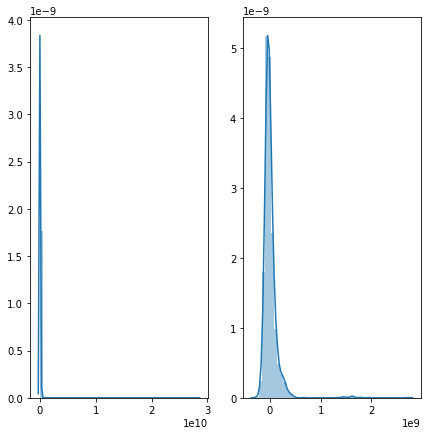

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharey=False)
sns.distplot(y_train, ax=axes[0], label='')
sns.distplot(lr.predict(x_train), ax=axes[1]);

О, графиката беше така в началото - преди да махнем данните на троловете. Ще трябва да обработя и _train и _test.

In [74]:
y_train.columns

Index(['Compensation'], dtype='object')

In [75]:
rows_to_delete = y_train[y_train['Compensation'] >= 1e+6].index
print('редове за премахване:', rows_to_delete)
y_train.drop(rows_to_delete, inplace=True)
x_train.drop(rows_to_delete, inplace=True)
y_train.sort_values('Compensation', ascending=False)[:10].style.apply(lambda x: ['background: lightgreen' if x.name == 'Compensation' and z >= 400000 else '' for i,z in x.iteritems()])

редове за премахване: Int64Index([993, 11689, 12531, 11970, 15678, 5458, 1514, 3013, 4481], dtype='int64')


/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Compensation
10601,699090
12623,690000
15494,550000
9224,500000
3743,400000
7621,371294
8669,364152
11630,350000
5696,350000
6023,350000


Ретрениране

In [76]:
lr = LinearRegression().fit(x_train, y_train)
lr.score(x_train, y_train)

0.49258298652223281

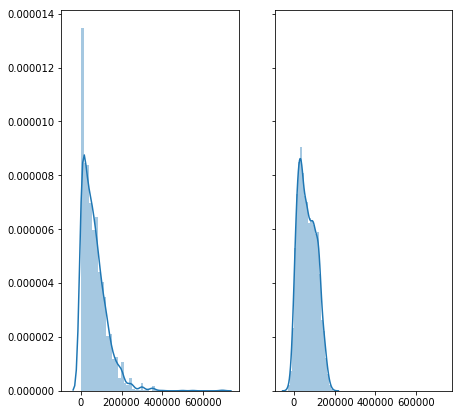

In [77]:
predictions_train = lr.predict(x_train)
fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharey=True, sharex=True)
sns.distplot(y_train, ax=axes[0], label='original')
sns.distplot(predictions_train, label='predicted', ax=axes[1]);

Да видим какво ще излезе за _test - първо трябва да оправим данните:

In [78]:
try:
    label_encoded_x_test = pd.DataFrame({col: label_encoders[col].transform(x_test[col])
                                    for col in label_encoders.keys()}, 
                                    index = data.index)
    label_encoded_x_test
except TypeError as e:
    print(e)

'<' not supported between instances of 'float' and 'str'


Пълна каша е - кога какво и колко е encoded.

In [79]:
label_encoders.keys()

dict_keys(['Country', 'Job', 'Sex'])

In [80]:
for c in x_test['Country']:
    if not c in label_encoders['Country'].classes_:
        print(c, c in label_encoders['Country'].classes_)

nan False


Damn you NaN

In [81]:
label_encoded_x_test = pd.DataFrame({col: label_encoders[col].transform(x_test[col].fillna(''))
                                    for col in label_encoders.keys()}, 
                                    index = x_test.index)
label_encoded_x_test

,Country,Job,Sex
3373,51,7,3
1633,2,6,3
10937,32,7,3
10630,6,10,3
10137,14,15,3
...,...,...,...
1945,47,13,3
572,51,1,3
1303,24,7,3
3025,4,2,3


In [82]:
hot = one_hot_encoder.transform(label_encoded_x_test)
hot_encoded_x_test = pd.DataFrame(hot.todense(), index=x_test.index, columns=new_columns)
hot_encoded_x_test

concatenated_x_test = pd.concat([x_test, hot_encoded_x_test], axis=1)
concatenated_x_test

x_test = concatenated_x_test.drop(label_encoders.keys(), axis=1)
x_test.Age.fillna(x_test.Age.mean(), inplace=True)
x_test
try:
    print(' test data score:', lr.score(x_test, y_test))
except ValueError as e:
    print(e)

could not convert string to float: 'Newsletters,Official documentation,Online courses,Stack Overflow Q&A,Textbook'


Вярно че и това го имаше.

In [83]:
x_test.Platform.shape

(1313,)

In [84]:
encoded_platforms_x_test = pd.DataFrame(cv.transform(x_test.Platform).todense(), index=x_test.index, columns=cv.get_feature_names())
encoded_platforms_x_test

concatenated_x_test = pd.concat([x_test, encoded_platforms_x_test], axis=1)
concatenated_x_test

x_test = concatenated_x_test.drop(['Platform'], axis=1)
x_test

,Age,Country_,Country_Argentina,Country_Australia,Country_Belarus,Country_Belgium,Country_Brazil,Country_Canada,Country_Chile,Country_Colombia,...,official documentation,online courses,other,personal projects,podcasts,stack overflow q&a,textbook,trade book,tutoring/mentoring,youtube videos
3373,30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,1,0,1,0,1,0,0,0,0
1633,32.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,0
10937,35.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,1,0,0,0,0,0,0
10630,41.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,1,0,0,0,1,1,0,0,0,1
10137,27.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,24.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,1,0,1,1
572,23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,0,0,0,0,1
1303,22.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,1,0,0,0
3025,40.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0,1,0,1,1,1,0,0,0,1


In [85]:
x_test.Age.fillna(x_test.Age.mean(), inplace=True)

In [86]:
rows_to_delete = y_test[y_test['Compensation'] >= 1e+6].index
# print('редове за премахване:', rows_to_delete)
y_test.drop(rows_to_delete, inplace=True)
x_test.drop(rows_to_delete, inplace=True)
y_test.sort_values('Compensation', ascending=False)[:10].style.apply(lambda x: ['background: lightgreen' if x.name == 'Compensation' and z >= 400000 else '' for i,z in x.iteritems()])

редове за премахване: Int64Index([8880, 12808, 804], dtype='int64')


/home/bob/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Compensation
2538,595885
419,470000
9206,459000
6357,400000
6301,400000
9247,359260
4803,350000
197,305000
13576,300000
13503,298956


Каква е оценката на линейната регресия за _test данните?

In [88]:
print(' test data score:', lr.score(x_test, y_test))

 test data score: -4.14172635648e+21


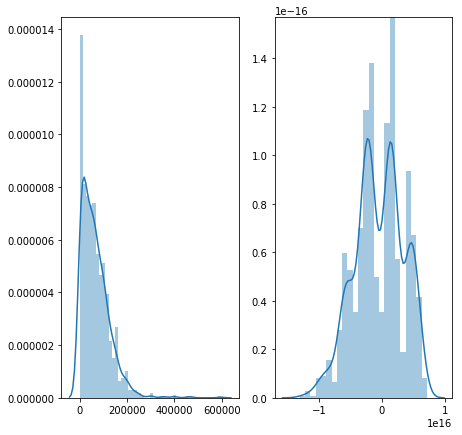

In [89]:
predictions_test = lr.predict(x_test)

fig, axes = plt.subplots(1, 2, figsize=(7, 7), sharey=False, sharex=False)
sns.distplot(y_test, ax=axes[0], label='original')
sns.distplot(predictions_test, label='predicted', ax=axes[1]);
# sns.distplot(predictions, label='predictions on the test set');

Нещо е яко сбъркано. Я да видим как са свързани Age и Compensation

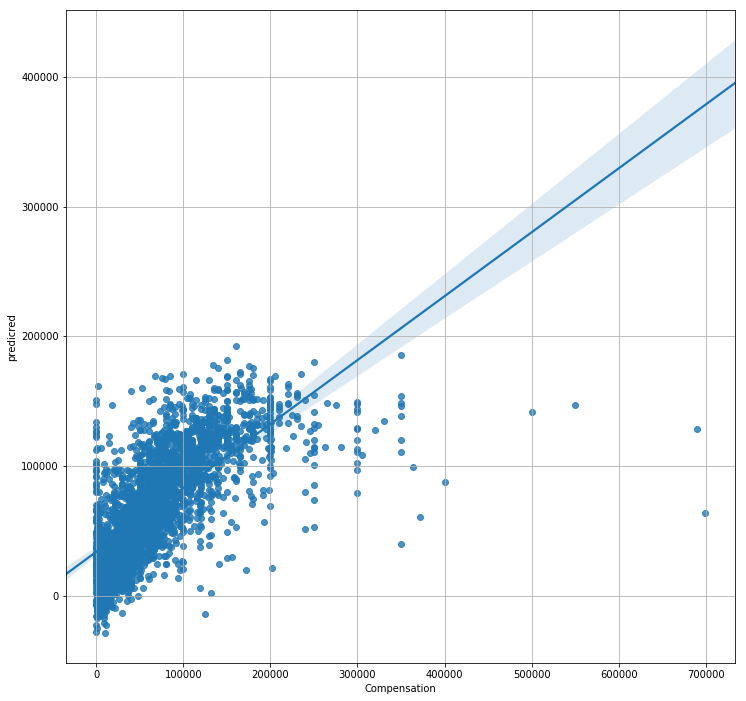

In [90]:
predictions_train = pd.Series(lr.predict(x_train).T[0], name='predicred')

plt.figure(figsize=(12,12))
sns.regplot(y_train.Compensation, predictions_train)
plt.grid(True)
plt.show()

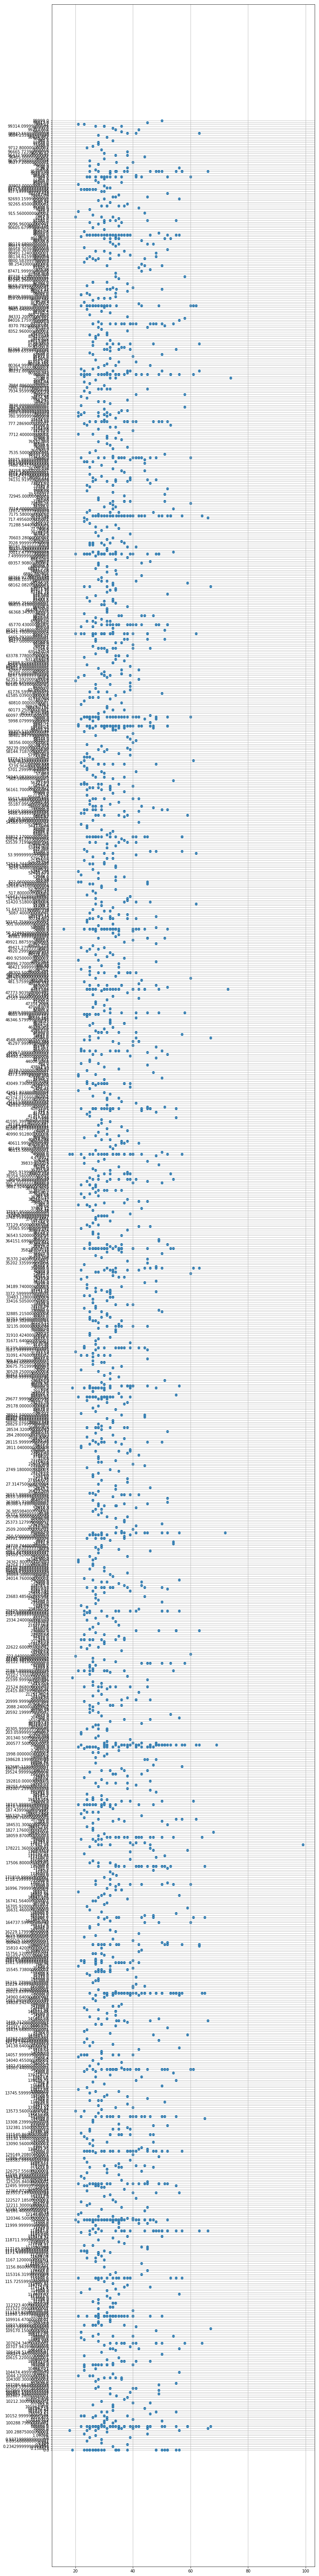

In [95]:
pd.options.display.max_rows = 120
plt.figure(figsize=(12,120))
plt.scatter(x_train.Age, y_train)
plt.grid(True)
plt.show()

Явно с това е трябвало да започна - определено плаче за скалиране на данните, но ми се струва че дори след това няма да има релация между Age и Compensation.

In [92]:
pd.options.display.max_rows = 20
from sklearn.preprocessing import StandardScaler

scaled_x_trn = StandardScaler().fit_transform(x_train)
scaled_x_train = pd.DataFrame(scaled_x_trn, index=x_train.index, columns=x_train.columns)
scaled_y_train = StandardScaler().fit_transform(y_train)

Преди да тренираме, да видим скалираните Age и Compensation на графика.

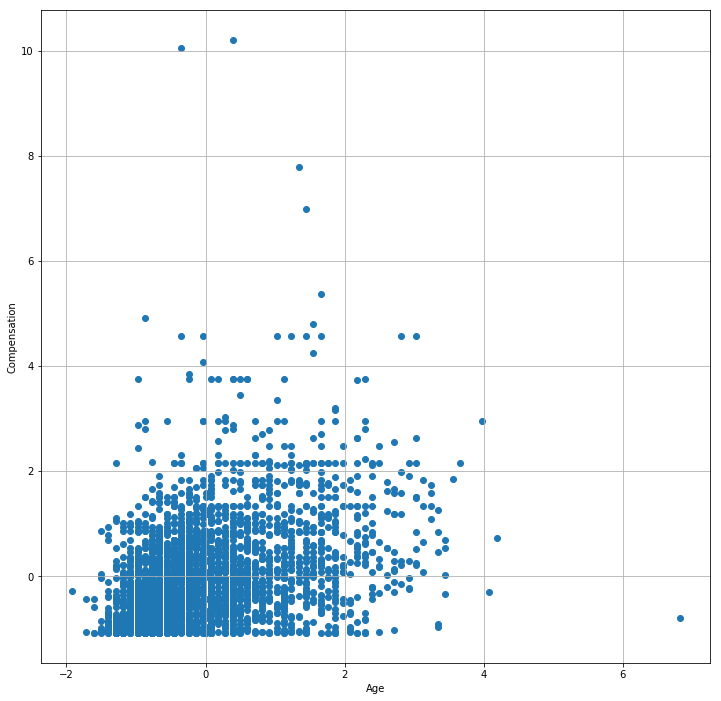

In [93]:
plt.figure(figsize=(12,12))
plt.scatter(scaled_x_train.Age, scaled_y_train)
plt.xlabel('Age')
plt.ylabel('Compensation')
plt.grid(True)
plt.show()

In [94]:
scaled_lr = LinearRegression().fit(scaled_x_train, scaled_y_train)
print('train data score:', lr.score(scaled_x_train, scaled_y_train))

train data score: -4.14823892082e+31


Това е оценката на данни с които тренирахме - дори няма да пробвам тестовите. Извода е, че няма никаква релация в данните.

TIL kак е на български [outliers](https://translate.google.com/#en/bg/outliers)